In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft

from funcoes import centro_gravidade

### Lendo arquivo de audio

"palma.wav" é um arquivo de áudio que eu gravei batendo uma palma

In [2]:
palma = "audios/assobio_agudo.wav"
taxa_amostragem, dados = wavfile.read(palma)

print ("Taxa de amostragem do arquivo de audio:", taxa_amostragem)
print ("Número de amostras:", dados.shape)

Taxa de amostragem do arquivo de audio: 8000
Número de amostras: (38000,)


### Visualizando o audio

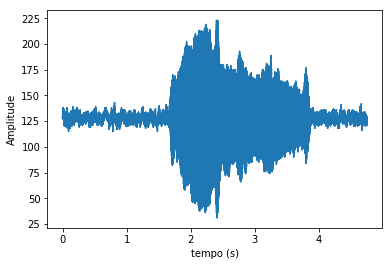

In [3]:
# tempos são os números das amostras, começando de 0
tempos = np.arange(0, dados.shape[0], 1)
# agora, tempos passa a ser o tempo de cada amostra
tempos = (tempos / taxa_amostragem)

plt.plot(tempos, dados)
plt.ylabel("Amplitude")
plt.xlabel("tempo (s)")
plt.show()

Dá pra notar exatamente onde é apenas ruído de ambiente, e quando foi que eu bati a palma

### Analisando na frequência

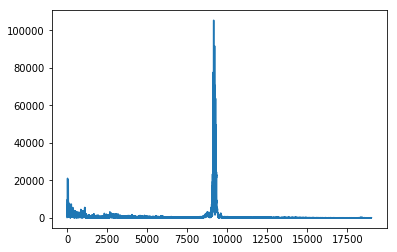

In [4]:
dados_frequencia = fft(dados)
plt.plot(np.abs(dados_frequencia[1:dados.shape[0]//2]))
plt.show()

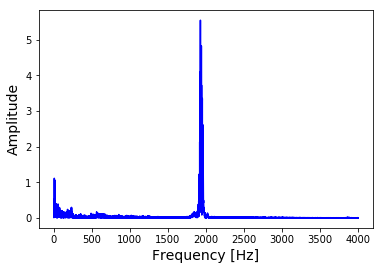

In [5]:
def get_fft_values(sampling_rate, data):
    size = data.shape[0]
    f_values = np.linspace(0.0, sampling_rate/2.0, size//2)
    fft_values_ = fft(data)
    fft_values = 2.0/size * np.abs(fft_values_[0:size//2])
    return f_values, fft_values

f_values, fft_values = get_fft_values(taxa_amostragem, dados)
 
plt.plot(f_values[1:], fft_values[1:], linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.show()

####  Observação
Quando formos plotar o espectro de frequência, devemos descartar o que estiver na origem (frequência = 0Hz).

Isso é porque a transformada de Fourrier é para sinais periódicos. Quando a aplicamos para um sinal não periódico (que tem frequência zero), a transformada dá um negócio muito forte na frequência DC.

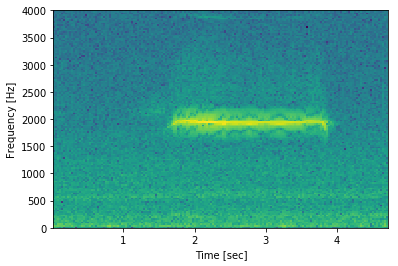

In [6]:
frequencies, times, spectrogram = signal.spectrogram(dados, taxa_amostragem)

plt.pcolormesh(times, frequencies, np.log(spectrogram))
# plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

### Iterando nos arquivos de áudio do diretório

Para cada arquivo de áudio, vamos plotá-lo no tempo, depois fazer a FFT e plotá-lo na frequência, e então plotar seu espectograma

Observação: o pontinho vermelho indica o centro de massa da frequência (no eixo x) e média (no eixo y)


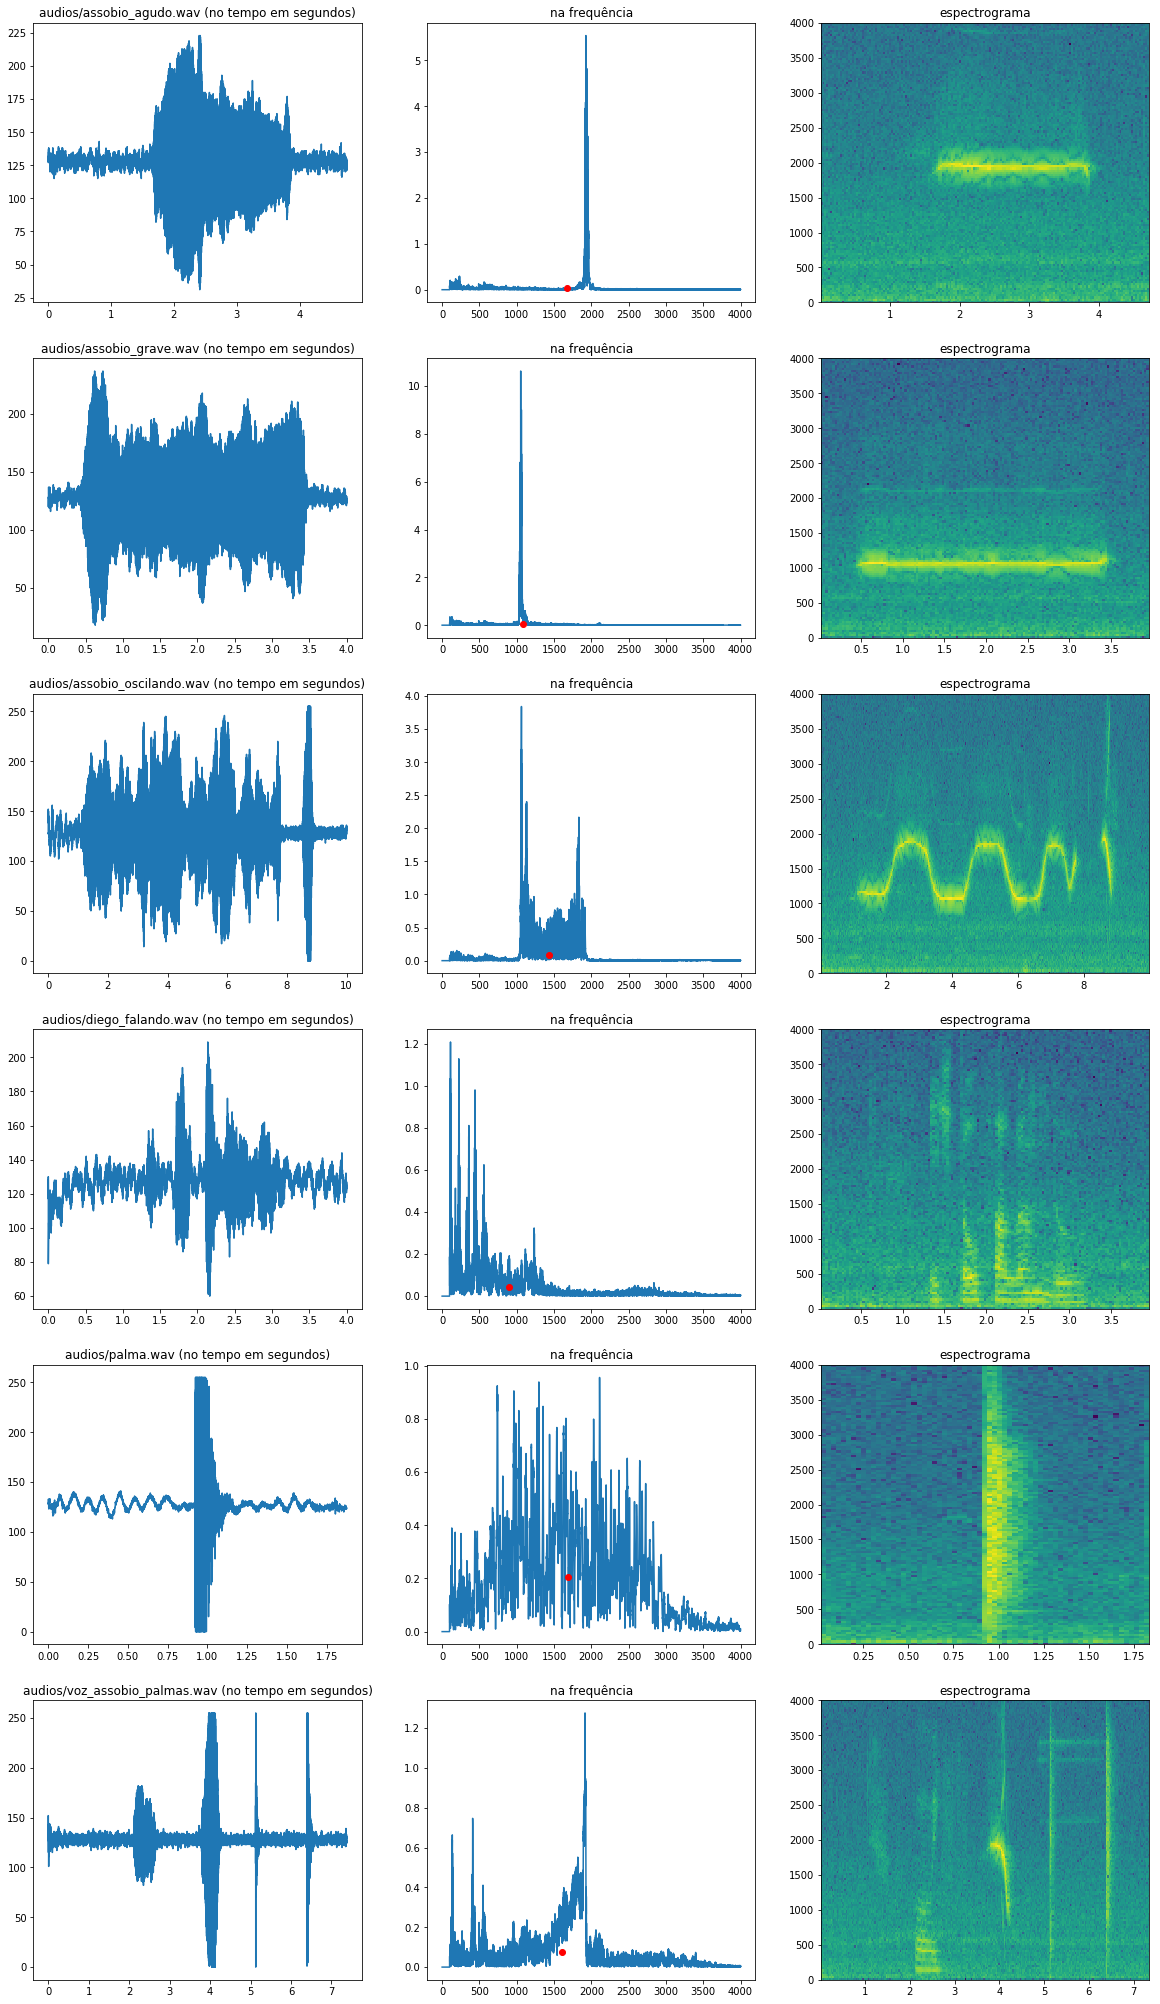

In [14]:
# Preparando os arquivos que serão lidos
dir_audios = "audios"
arquivos_audio = [os.path.join(dir_audios, arq_audio) for arq_audio in os.listdir(dir_audios)]

# Preparando o gráfico com 3 colunas e n linhas: para cada audio,
# vamos plotar no tempo, na frequência e seu espectrograma
qtd_audios = len(arquivos_audio)
altura_por_grafico = 6
figura, eixos = plt.subplots(qtd_audios, 3, figsize=(20,altura_por_grafico * qtd_audios))

for i, arq_audio in enumerate(arquivos_audio):
    # ler arquivo de audio
    taxa_amostragem, dados = wavfile.read(arq_audio)
    
    """
    NO TEMPO
    """    
    
    # tempos são os números das amostras, começando de 0
    tempos = np.arange(0, dados.shape[0], 1)
    # agora, tempos passa a ser o tempo de cada amostra
    tempos = (tempos / taxa_amostragem)
    
    grafico = eixos[i][0]
    grafico.plot(tempos, dados)
    grafico.set_title(arq_audio + " (no tempo em segundos)")
    
    """
    NA FREQUÊNCIA
    """
    # Encontrar a transformada e plotá-la (lembrando de descartar a frequência DC)
    
    f_values, fft_values = get_fft_values(taxa_amostragem, dados)
    
    passa_altas = 100
    
    # Abaixo, estou zerando todas as frequências que não estão acima de passa_altas.
    # Isso porque achei que as frequências muito baixas estavam interferindo muito,
    # considerando aquele problema que a transformada de fourier tem com séries
    # não periódicas.
    fft_values = np.array([fft_values[i] if f_values[i] > passa_altas else 0 for i in range(len(f_values))])
    
    frequencies, times, spectrogram = signal.spectrogram(dados, taxa_amostragem)

    grafico = eixos[i][1]
    grafico.plot(f_values[1:], fft_values[1:])
    grafico.set_title("na frequência")
    
    
    # Encontrar a "potência" média
    
    media = statistics.mean(fft_values)
    
    # Encontrar o centro de gravidade do espectro de frequência
    
    centro_g = centro_gravidade(f_values[1:], fft_values[1:])
    
    # plotar uma bolinha vermelha (em 'ro', r' dá red e 'o' dá bolinha)
    grafico.plot(centro_g, media, 'ro')
    
    """
    ESPECTROGRAMA
    """
    
    grafico = eixos[i][2]
    grafico.pcolormesh(times, frequencies, np.log(spectrogram))
    grafico.set_title("espectrograma")
    


print("Observação: o pontinho vermelho indica o centro de massa da frequência (no eixo x) e média (no eixo y)")
plt.show()